<a href="https://colab.research.google.com/github/Khang2561/Intrusion-detection-using-DL-and-MC/blob/main/mordeling_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Read file


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#đọc dữ liệu file train và test
#train
path = "/content/drive/MyDrive/Project/intruction_detection_project/kdd_train.csv"
train_df = pd.read_csv(path)

#test
path = "/content/drive/MyDrive/Project/intruction_detection_project/kdd_test.csv"
test_df = pd.read_csv(path)

In [ ]:
#Phân loại những data có kiểu category
#change Dtype
features = ["protocol_type","service","flag","land","wrong_fragment","is_host_login","urgent","logged_in","root_shell","su_attempted","is_guest_login","labels"]
def convert_cat(df,features) :
  for feature in features :
    df[feature] = df[feature].astype("category")
convert_cat(train_df, features)
convert_cat(test_df, features)

In [ ]:
#xóa những cột không quá ảnh hưởng đến bài trên train_df
train_df = train_df.drop(labels ='num_outbound_cmds',axis = 1)
train_df = train_df.drop(labels ='is_host_login',axis = 1)

In [ ]:
#những thuộc tính số lượng dưới 1 gộp thành vào other
label_better_1 = ["normal","neptune","satan","ipsweep","portsweep","smurf","nmap"]
train_df_labels_1 = list(train_df['labels'].unique())
train_df_labels_1 = set(train_df_labels_1) - set(label_better_1)
train_df_labels_1

test_df_labels_1 = list(test_df['labels'].unique())
test_df_labels_1 = set(test_df_labels_1) - set(label_better_1)
test_df_labels_1

#train_df.loc[label_under_1, ['labels']] ='other'
train_df['labels'] = train_df['labels'].replace(train_df_labels_1, 'other')
#train_df
test_df['labels'] = test_df['labels'].replace(test_df_labels_1, 'other')

In [ ]:
#xóa vì num_root tương quan numcompromised đến 1
train_df = train_df.drop(labels ='num_root',axis = 1)
test_df = test_df.drop(labels ='num_root',axis = 1)

In [ ]:
#copy file
cut_train_df = train_df.copy()
cut_test_df = test_df.copy()

In [ ]:
#tách label normal và neptune trong tập train
cut_train__normal_slice = cut_train_df[cut_train_df['labels']=='normal'].copy()
cut_train__neptune_slice = cut_train_df[cut_train_df['labels']=='neptune'].copy()


In [ ]:
random_state =42
#lấy ngẫu nhiên 5000 dòng dữ liệu từ 2 bảng normal và neptune của train
proc_train_normal_sampled = cut_train__normal_slice.sample(n=5000, random_state=random_state)
proc_train_neptune_sampled = cut_train__neptune_slice.sample(n=5000, random_state=random_state)

In [ ]:
# xóa dữ liệu có label normal và nepture trong bảng nerual_train__normal_slice
cut_train__normal_slice.drop(cut_train__normal_slice.loc[cut_train__normal_slice['labels']=='normal'].index, inplace=True)
cut_train__normal_slice.drop(cut_train__normal_slice.loc[cut_train__normal_slice['labels']=='neptune'].index, inplace=True)

In [ ]:
cut_train_df.drop(cut_train_df.loc[cut_train_df['labels']=='normal'].index, inplace=True)
cut_train_df.drop(cut_train_df.loc[cut_train_df['labels']=='neptune'].index, inplace=True)

In [ ]:
#nối lại vào bảng với các giá trị đã cắt
cut_train_df = pd.concat([cut_train_df, proc_train_normal_sampled, proc_train_neptune_sampled], axis=0)


Text(0.5, 1.0, 'labels')

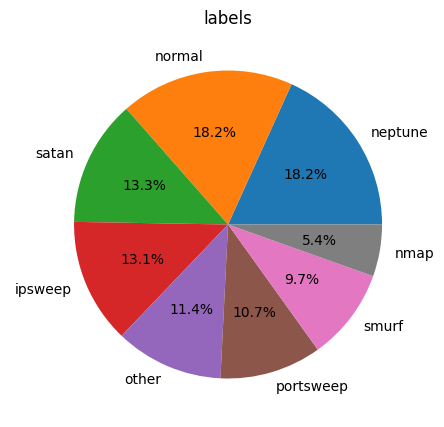

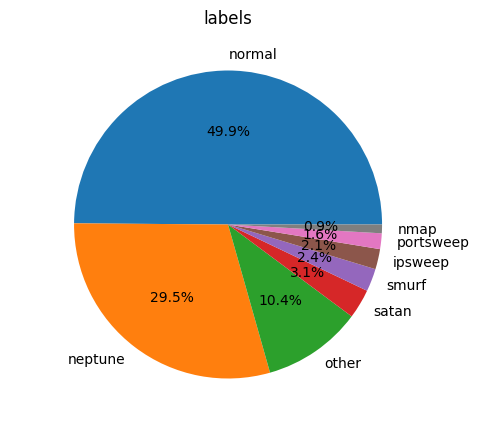

In [ ]:
#train
grouped_df = (cut_train_df.groupby('labels').size()/len(cut_train_df))*100

grouped_df = grouped_df.sort_values(ascending=False)

fig = plt.figure(figsize=(5,5))
grouped_df.plot(kind = 'pie', autopct='%.1f%%')
plt.ylabel(" ", fontsize = 15)
plt.title("labels")
#test
grouped_df = (test_df.groupby('labels').size()/len(cut_train_df))*100

grouped_df = grouped_df.sort_values(ascending=False)

fig = plt.figure(figsize=(5,5))
grouped_df.plot(kind = 'pie', autopct='%.1f%%')
plt.ylabel(" ", fontsize = 15)
plt.title("labels")

In [ ]:
#giảm độ lệch chuyển trong dữ liệu
norm_cols = [ 'duration', 'src_bytes', 'dst_bytes', 'hot', 'num_compromised', 'num_file_creations', 'count', 'srv_count', 'dst_host_count', 'dst_host_srv_count']

for col in norm_cols:
    cut_train_df[col] = np.log(cut_train_df[col]+1e-6)
    cut_test_df[col] = np.log(cut_test_df[col]+1e-6)


In [ ]:
feature_cols = [i for i in train_df if i != 'labels']
x = cut_train_df[feature_cols]
y = cut_train_df['labels']
X_test =cut_test_df[feature_cols]
y_test = cut_test_df['labels']


In [ ]:
#preprocess pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
num_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps =[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


In [ ]:
num_features = [i for i in train_df if i != 'labels' and train_df[i].dtype != 'category']
cat_features = [i for i in train_df if i != 'labels' and train_df[i].dtype == 'category']

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [ ]:
preprocessor.fit(x)
preprocessor.fit(X_test)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['duration', 'src_bytes', 'dst_bytes', 'hot',
                                  'num_failed_logins', 'num_compromised',
                                  'num_file_creations', 'num_shells',
                                  'num_access_files', 'count', 'srv_count',
                                  'serror_rate', 'srv_serror_rate',
                                  'rerror_rate', 'srv_rerror_rate',
                                  'sa...
                                  'dst_host_serror_rate',
                                  'dst_host_srv_serror_rate',
                                  'dst_host_rerror_rate',
                                  'dst_host_srv_rerror_rate']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['protocol_type', 'service', 'flag', 'land',
                                  'wrong_fragment', 'urgent', 'logged_in',
                                  'root_shell', 'su_attempted',
                                  'is_guest_login'])])

In [ ]:
X = preprocessor.transform(x)#X -> X_train, X_val
X_test =preprocessor.transform(X_test)

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, y_train,y_val = train_test_split(X,y, test_size = 0.2)

In [ ]:

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
#binary classification
from sklearn.preprocessing import PolynomialFeatures
#sklearn model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score,classification_report, confusion_matrix

Logistic Regression

In [ ]:
lrc = LogisticRegression()

lrc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
y_pred = lrc.predict(X_test)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer

# Showing Confusion Matrix

def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    #y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

0.8394876755064047

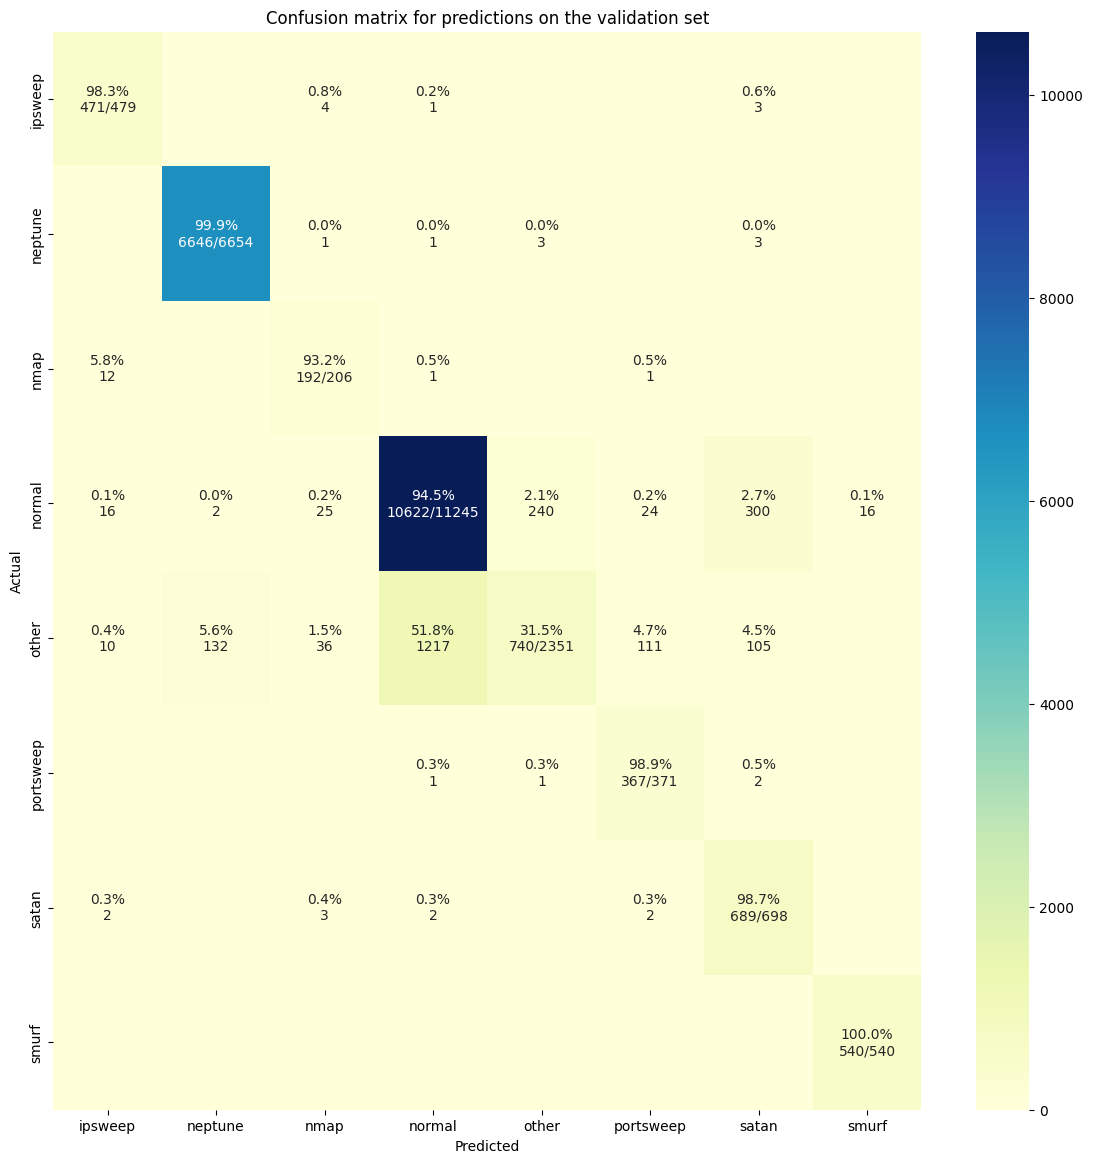

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

#CNN Model

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)


In [ ]:
y_pred = clf.predict(X_test)

0.8755146237817988

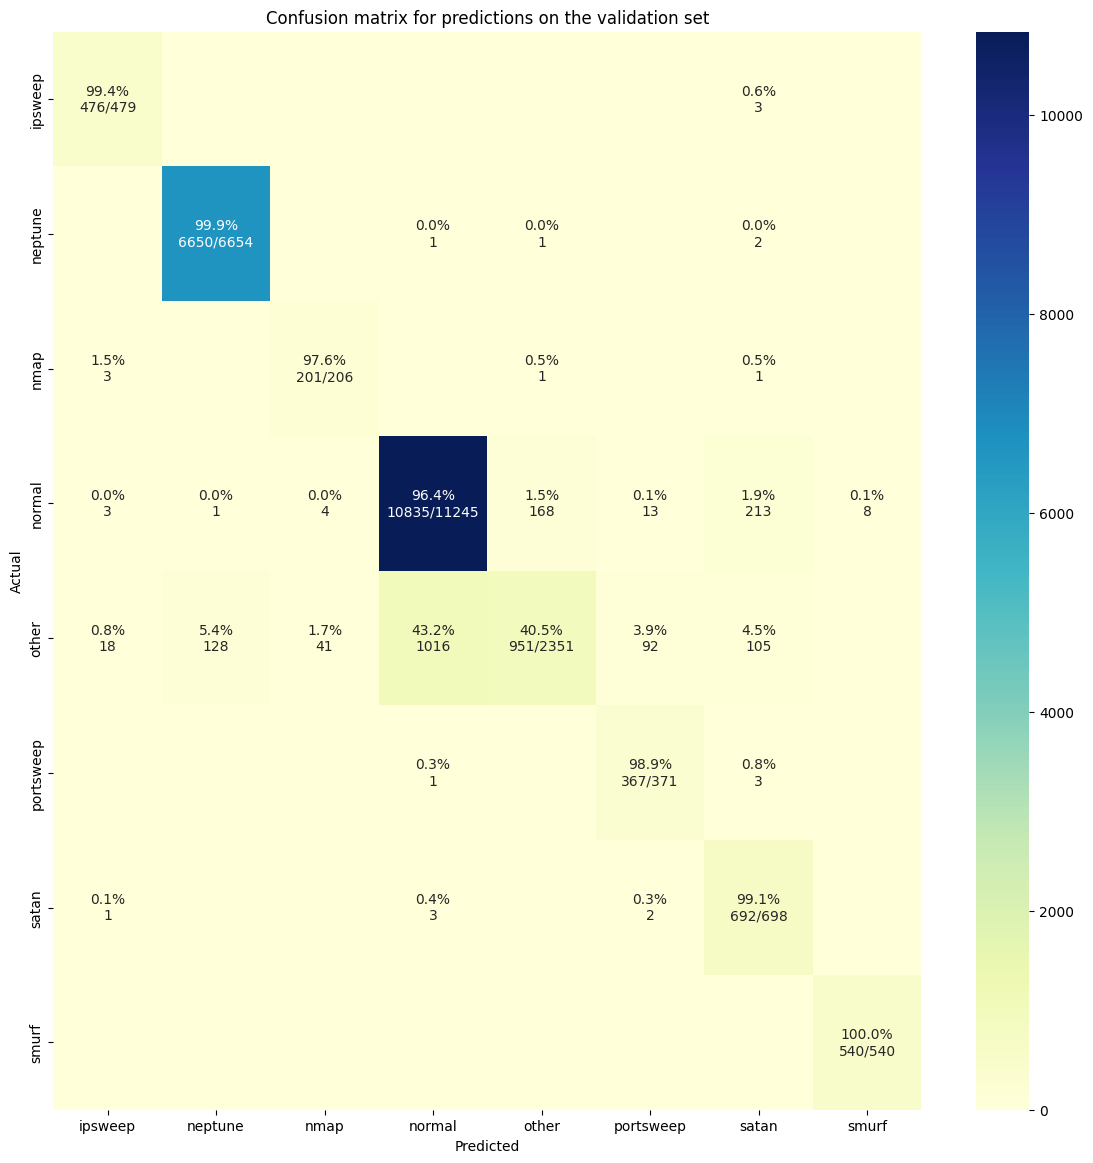

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

#naive_bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train,y_train)


GaussianNB()

In [ ]:
y_pred = model.predict(X_test)

0.5132975352808697

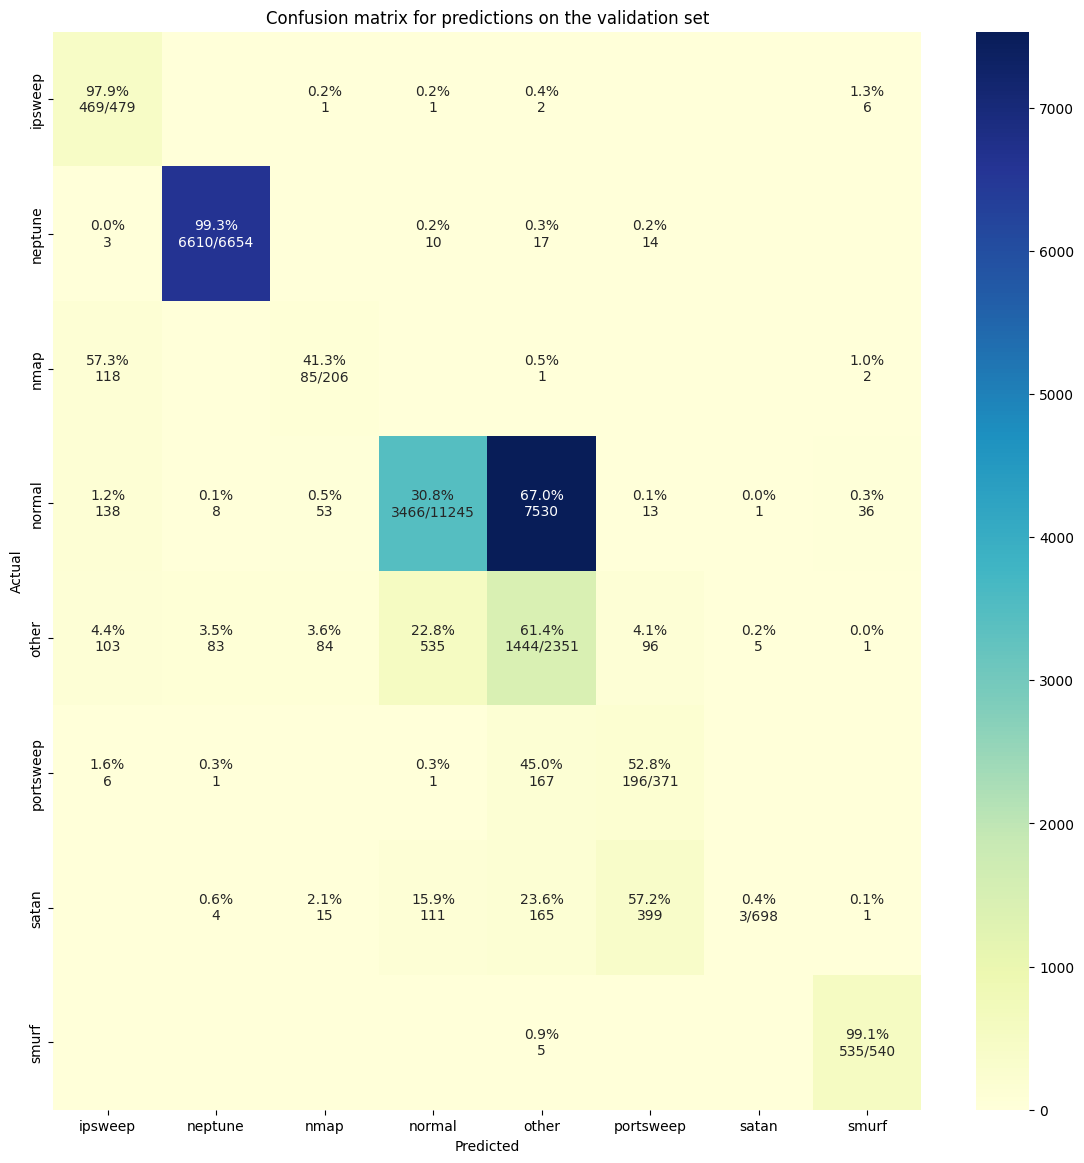

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

#RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:


model = RandomForestClassifier()
model.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred = model.predict(X_test)

0.89559650131254

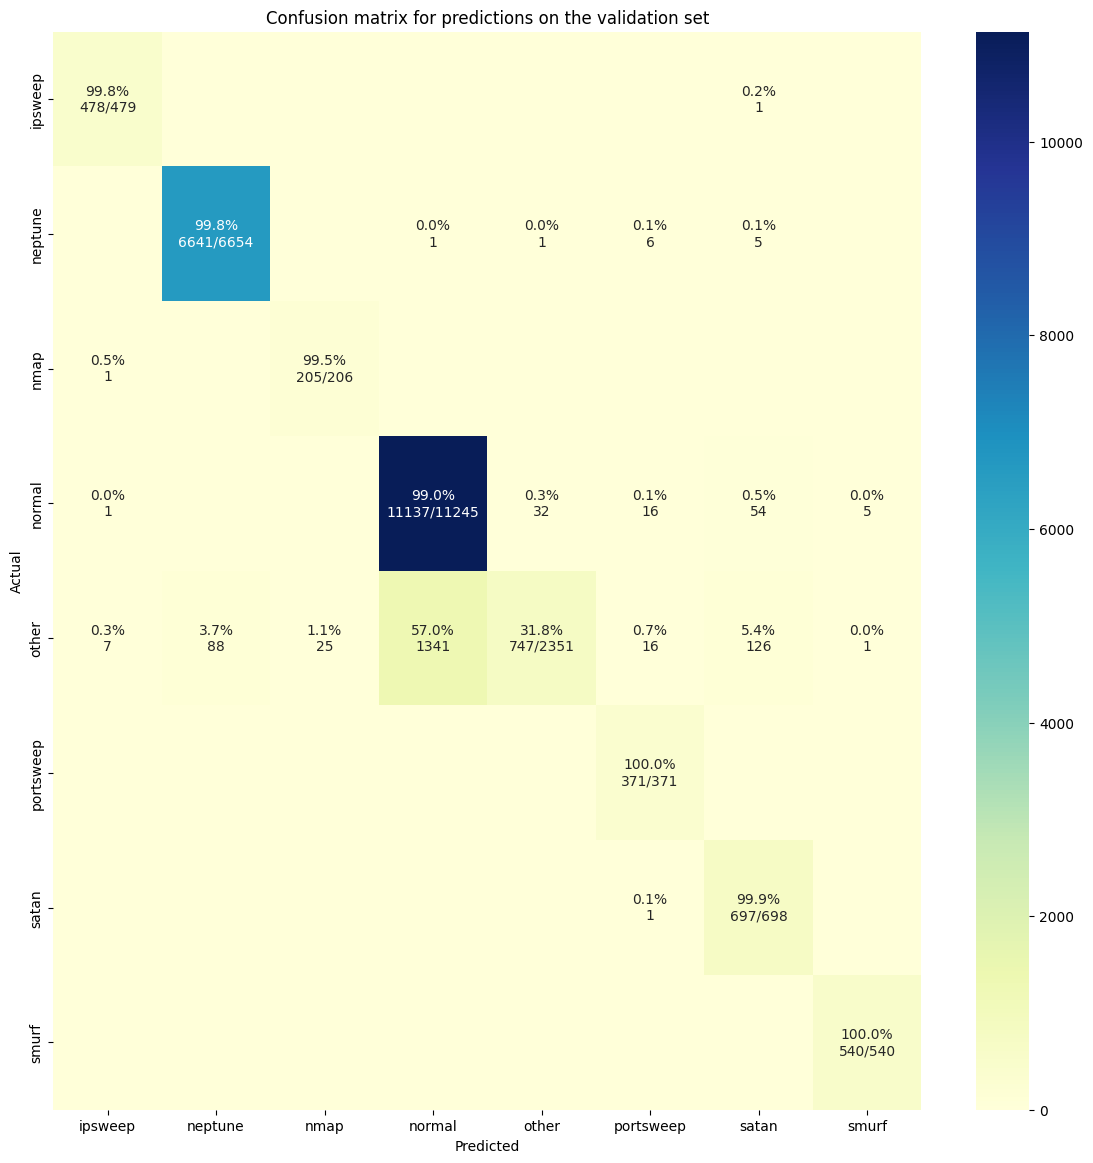

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

#SVC

In [ ]:
from sklearn.svm import SVC
import numpy as np
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
y_pred =clf.predict(X_test)

0.8420961322120335

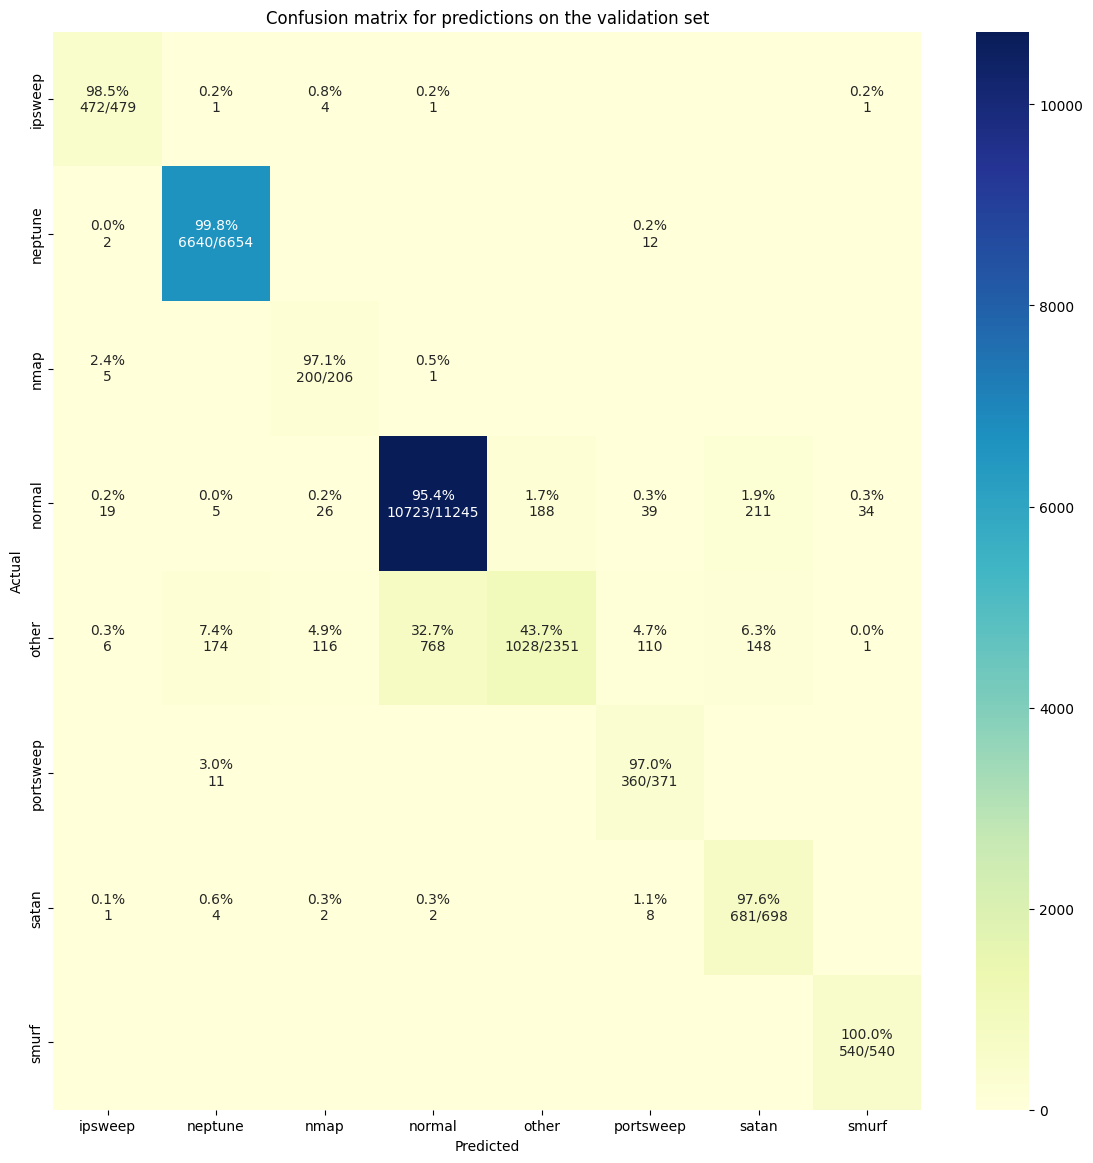

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

#SVM

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
y_pred =clf.predict(X_test)

0.8657273088905866

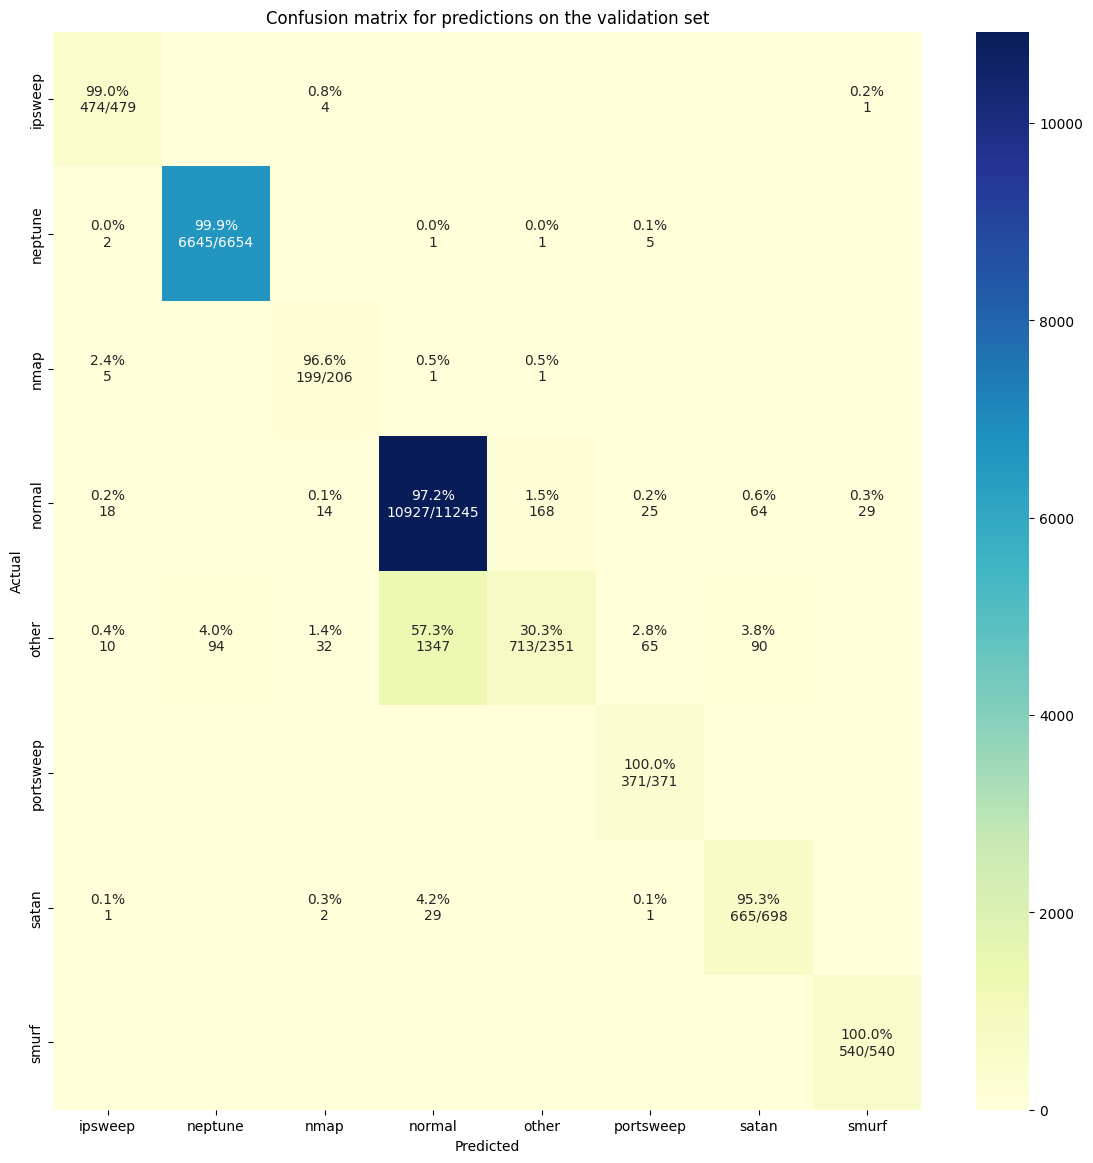

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

adsfasf

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, BatchNormalization, Dropout
#from tensorflow.keras.layers.core import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score
#from tensorflow.keras.metrics import

train size: 100778
test size:   25195


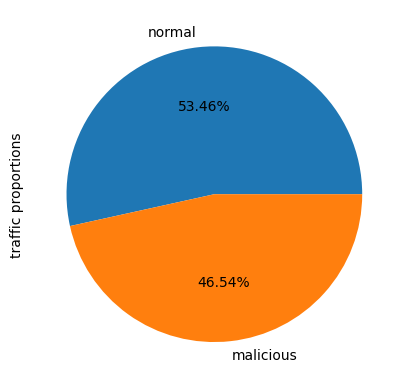

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

df=pd.read_csv("/content/drive/MyDrive/Project/intruction_detection_project/kdd_train.csv")

numeric_columns = []
categorical_columns = []
for column in df.columns:
    if df[column].dtype != 'object':
        numeric_columns.append(column)
    else:
        categorical_columns.append(column)

binary_class = []
for label in df['labels']:
    if label !='normal':
        binary_class.append('malicious')
    else:
        binary_class.append('normal')
binary_class = pd.Series(binary_class)
plt.figure()
binary_class.value_counts().plot(kind='pie', label='traffic proportions', autopct='%.2f%%' );


categorical_columns = categorical_columns[:-1]
labels=df['labels'].unique()

dummies = pd.get_dummies(df[categorical_columns])
x = pd.concat((df[numeric_columns], dummies), axis=1).values

enc_bin = LabelEncoder()
y_bin = enc_bin.fit_transform(binary_class)
enc_multi = LabelEncoder()
y_multi = enc_multi.fit_transform(df['labels'].values)

# for manual train_test_split, splitting indices instead of actual values
np.random.RandomState(seed=0)
train_indexes = np.random.choice(np.arange(x.shape[0]), size=x.shape[0]*8//10, replace=False)
test_indexes = np.delete(np.arange(x.shape[0]), np.arange(x.shape[0])[train_indexes])
print('train size:', train_indexes.shape[0])
print('test size:  ', test_indexes.shape[0])

x_tr = x[train_indexes]
x_ts = x[test_indexes]
y_bin_tr =y_bin[train_indexes]
y_bin_ts =y_bin[test_indexes]
y_multi_tr = y_multi[train_indexes]
y_multi_ts = y_multi[test_indexes]

# scale x
sc=StandardScaler()
x_tr = sc.fit_transform(x_tr)
x_ts = sc.transform(x_ts)

#make x 3-dimensional for the CNN to process
x_tr = x_tr[:,:,np.newaxis]
x_ts = x_ts[:,:,np.newaxis]

,class,label
0,back,0
1,buffer_overflow,1
2,ftp_write,2
3,guess_passwd,3
4,imap,4
5,ipsweep,5
6,land,6
7,loadmodule,7
8,multihop,8
9,neptune,9


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 121, 180)          540       
                                                                 
 batch_normalization_2 (Bat  (None, 121, 180)          720       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 60, 180)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 60, 180)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 59, 300)           108300    
                                                                 
 batch_normalization_3 (Bat  (None, 59, 300)          

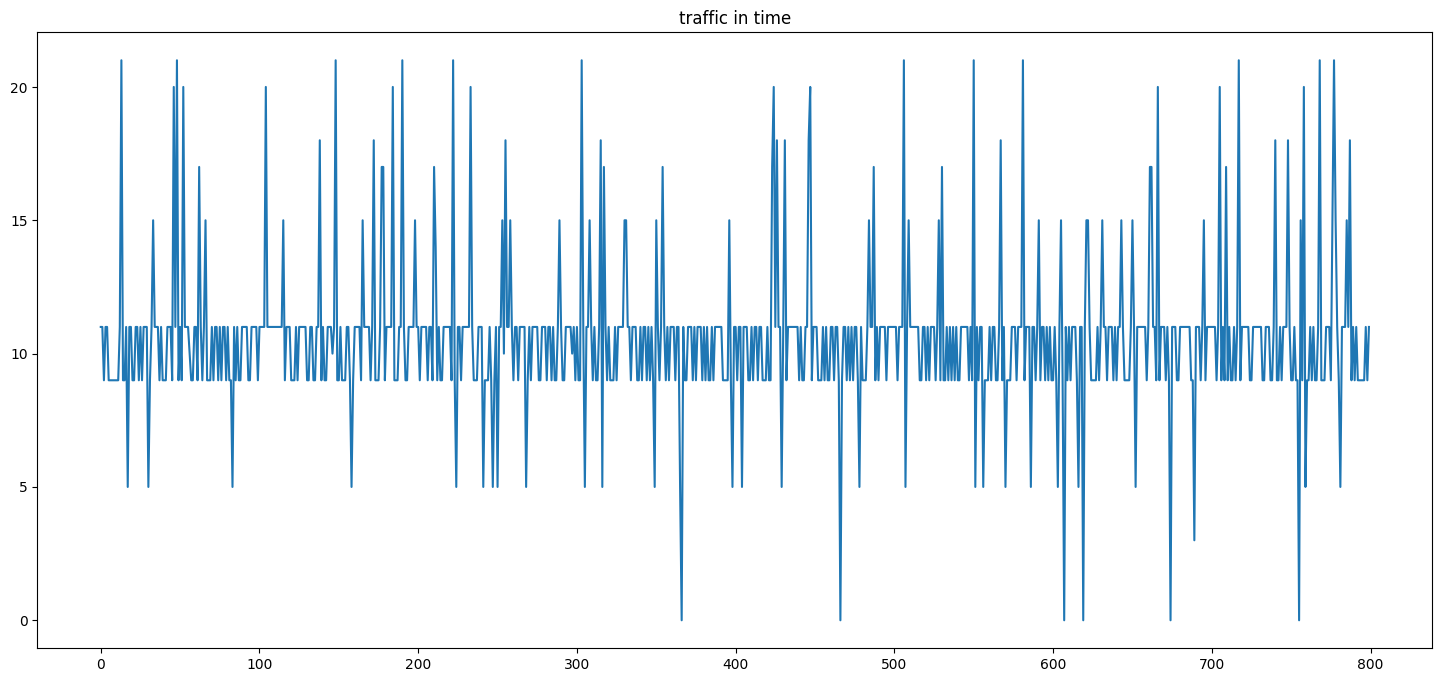

In [ ]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y = enc.fit_transform(df['labels'])
x = np.arange(y.shape[0])

plt.figure(figsize=(18,8));
sns.lineplot(x=x[:800], y=y[:800]); #for visual clarity, only a small slice is selected
plt.title('traffic in time')

class_labels = pd.DataFrame(data=enc.classes_,columns=['class'])
class_labels['label'] = np.unique(y)
display(class_labels)

model1=Sequential()
model1.add(Conv1D(180,2, activation='relu',input_shape=x_tr[0].shape))
model1.add(BatchNormalization())
model1.add(MaxPool1D(2))
model1.add(Dropout(0.2))

model1.add(Conv1D(300,2, activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPool1D(2))
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.4))

model1.add(Dense(len(np.unique(enc.classes_)),activation='softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

In [ ]:
early_stop = EarlyStopping(patience=4,verbose=1)
model1.fit(x_tr, y_multi_tr, epochs=30, validation_split=0.1, batch_size=16, callbacks=[early_stop])


Epoch 1/30
5669/5669 [==============================] - 451s 79ms/step - loss: 0.2042 - accuracy: 0.9572 - val_loss: 0.0767 - val_accuracy: 0.9856
Epoch 2/30
5669/5669 [==============================] - 415s 73ms/step - loss: 0.1024 - accuracy: 0.9755 - val_loss: 0.1402 - val_accuracy: 0.9848
Epoch 3/30
5669/5669 [==============================] - 405s 71ms/step - loss: 0.0889 - accuracy: 0.9785 - val_loss: 0.0769 - val_accuracy: 0.9857
Epoch 4/30
5669/5669 [==============================] - 408s 72ms/step - loss: 0.0744 - accuracy: 0.9816 - val_loss: 0.1044 - val_accuracy: 0.9852
Epoch 5/30
5669/5669 [==============================] - 387s 68ms/step - loss: 0.0675 - accuracy: 0.9826 - val_loss: 0.0816 - val_accuracy: 0.9857
Epoch 5: early stopping


In [ ]:
deep_val_pred

array([[0.99999994],
       [0.99999994],
       [0.99999994],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

In [ ]:
plot_cm(y_val, deep_val_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_val, deep_val_pred, average = 'macro')

ValueError: ignored

neuron


In [ ]:
X_train_reshaped = X_train.reshape(-1, 125)
X_train_reshaped.shape

(21932, 125)

In [ ]:
X_test_reshaped = X_test.reshape(-1, 125)
X_test_reshaped.shape

(22544, 125)

In [ ]:
y_train.unique()

['neptune', 'ipsweep', 'nmap', 'portsweep', 'other', 'normal', 'satan', 'smurf']
Categories (8, object): ['ipsweep', 'other', 'neptune', 'nmap', 'normal', 'portsweep', 'satan',
                         'smurf']

In [ ]:
lable_map = {'normal':0, 'neptune':1, 'satan':2, 'smurf':3, 'ipsweep':4, 'other':5, 'nmap':6, 'portsweep':7}
y_train = y_train.map(lable_map)
y_test = y_test.map(lable_map)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=8)


In [ ]:
#chuỗi cái layer
from keras.models import Sequential
model = Sequential()


In [ ]:
X_train.shape

(21932, 125)

In [ ]:
from keras.layers import Dense
Dense(125, input_shape=(125, ))
model.add(Dense(100, input_shape=(125, )))
model.add(Dense(75, input_shape=(100, )))
model.add(Dense(50, input_shape=(75, )))
model.add(Dense(25, input_shape=(50, )))
model.add(Dense(8, input_shape=(25, )))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 100)               12600     
                                                                 
 dense_32 (Dense)            (None, 75)                7575      
                                                                 
 dense_33 (Dense)            (None, 50)                3800      
                                                                 
 dense_34 (Dense)            (None, 25)                1275      
                                                                 
 dense_35 (Dense)            (None, 8)                 208       
                                                                 
Total params: 25458 (99.45 KB)
Trainable params: 25458 (99.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.output.shape

TensorShape([None, 8])

In [ ]:
#tối ưu hàm loss
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
loss = BinaryCrossentropy()

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
model.fit(X_train_reshaped, y_train, batch_size=10000, epochs=10)

Epoch 1/10
3/3 [==============================] - 1s 32ms/step - loss: 2.7174 - accuracy: 0.2201
Epoch 2/10
3/3 [==============================] - 0s 35ms/step - loss: 1.6817 - accuracy: 0.3723
Epoch 3/10
3/3 [==============================] - 0s 35ms/step - loss: 1.6623 - accuracy: 0.3663
Epoch 4/10
3/3 [==============================] - 0s 33ms/step - loss: 2.0193 - accuracy: 0.3654
Epoch 5/10
3/3 [==============================] - 0s 32ms/step - loss: 1.7228 - accuracy: 0.3758
Epoch 6/10
3/3 [==============================] - 0s 33ms/step - loss: 1.6893 - accuracy: 0.3581
Epoch 7/10
3/3 [==============================] - 0s 33ms/step - loss: 1.6425 - accuracy: 0.3557
Epoch 8/10
3/3 [==============================] - 0s 56ms/step - loss: 1.7101 - accuracy: 0.4143
Epoch 9/10
3/3 [==============================] - 0s 56ms/step - loss: 1.4432 - accuracy: 0.4105
Epoch 10/10
3/3 [==============================] - 0s 52ms/step - loss: 1.5692 - accuracy: 0.4027


In [ ]:
y_pred = model.predict(X_test_reshaped)

705/705 [==============================] - 3s 4ms/step


In [ ]:
y_pred_label = np.argmax(y_pred, axis=-1)

In [ ]:
plot_cm(y_test,y_pred_label, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred_label, average = 'macro')

NameError: ignored

In [ ]:
y_pred_label

In [ ]:
y_test

In [ ]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers

import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
X_train_reshaped = X_train.reshape(-1, 125)
X_train_reshaped.shape

(21932, 125)

In [ ]:
X_test_reshaped = X_test.reshape(-1, 125)
X_test_reshaped.shape

(22544, 125)

In [ ]:
X_val_reshaped = X_val.reshape(-1, 125)
X_val_reshaped.shape


(5484, 125)

In [ ]:
y_train.unique()

['satan', 'other', 'normal', 'ipsweep', 'neptune', 'portsweep', 'smurf', 'nmap']
Categories (8, object): ['other', 'ipsweep', 'neptune', 'nmap', 'normal', 'portsweep', 'satan',
                         'smurf']

In [ ]:
lable_map = {'normal':0, 'neptune':1, 'satan':2, 'smurf':3, 'ipsweep':4, 'other':5, 'nmap':6, 'portsweep':7}
y_train = y_train.map(lable_map)
y_test = y_test.map(lable_map)

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=8)

In [ ]:
y_val = y_val.map(lable_map)
y_val = to_categorical(y_val, num_classes=8)

In [ ]:
y_val

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
#chuỗi cái layer
from keras.models import Sequential
model = Sequential()


In [ ]:
X_train.shape

(21932, 125)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=125, activation='relu', input_shape=(125, ),
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=250, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=500, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=1000, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=2000, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=1000, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=500, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=250, activation='relu',
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.01),

    tf.keras.layers.Dense(units=8, activation='sigmoid'),
])

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               15750     
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               125500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 1000)             

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 125)               15750     
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               31500     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 500)               125500    
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_3 (Dense)             (None, 1000)             

In [ ]:
history = model.fit(X_train_reshaped, y_train,validation_data=(X_val, y_val) ,epochs=70, verbose=20000)

Epoch 1/70
Epoch 2/70
Epoch 3/70
Epoch 4/70
Epoch 5/70
Epoch 6/70
Epoch 7/70
Epoch 8/70
Epoch 9/70
Epoch 10/70
Epoch 11/70
Epoch 12/70
Epoch 13/70
Epoch 14/70
Epoch 15/70
Epoch 16/70
Epoch 17/70
Epoch 18/70
Epoch 19/70
Epoch 20/70
Epoch 21/70
Epoch 22/70
Epoch 23/70
Epoch 24/70
Epoch 25/70
Epoch 26/70
Epoch 27/70
Epoch 28/70
Epoch 29/70
Epoch 30/70
Epoch 31/70
Epoch 32/70
Epoch 33/70
Epoch 34/70
Epoch 35/70
Epoch 36/70
Epoch 37/70
Epoch 38/70
Epoch 39/70
Epoch 40/70
Epoch 41/70
Epoch 42/70
Epoch 43/70
Epoch 44/70
Epoch 45/70
Epoch 46/70
Epoch 47/70
Epoch 48/70
Epoch 49/70
Epoch 50/70
Epoch 51/70
Epoch 52/70
Epoch 53/70
Epoch 54/70
Epoch 55/70
Epoch 56/70
Epoch 57/70
Epoch 58/70
Epoch 59/70
Epoch 60/70
Epoch 61/70
Epoch 62/70
Epoch 63/70
Epoch 64/70
Epoch 65/70
Epoch 66/70
Epoch 67/70
Epoch 68/70
Epoch 69/70
Epoch 70/70


In [ ]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_pred = model.predict(X_test)

705/705 [==============================] - 9s 13ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=-1)

In [ ]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

0.8597609839914213

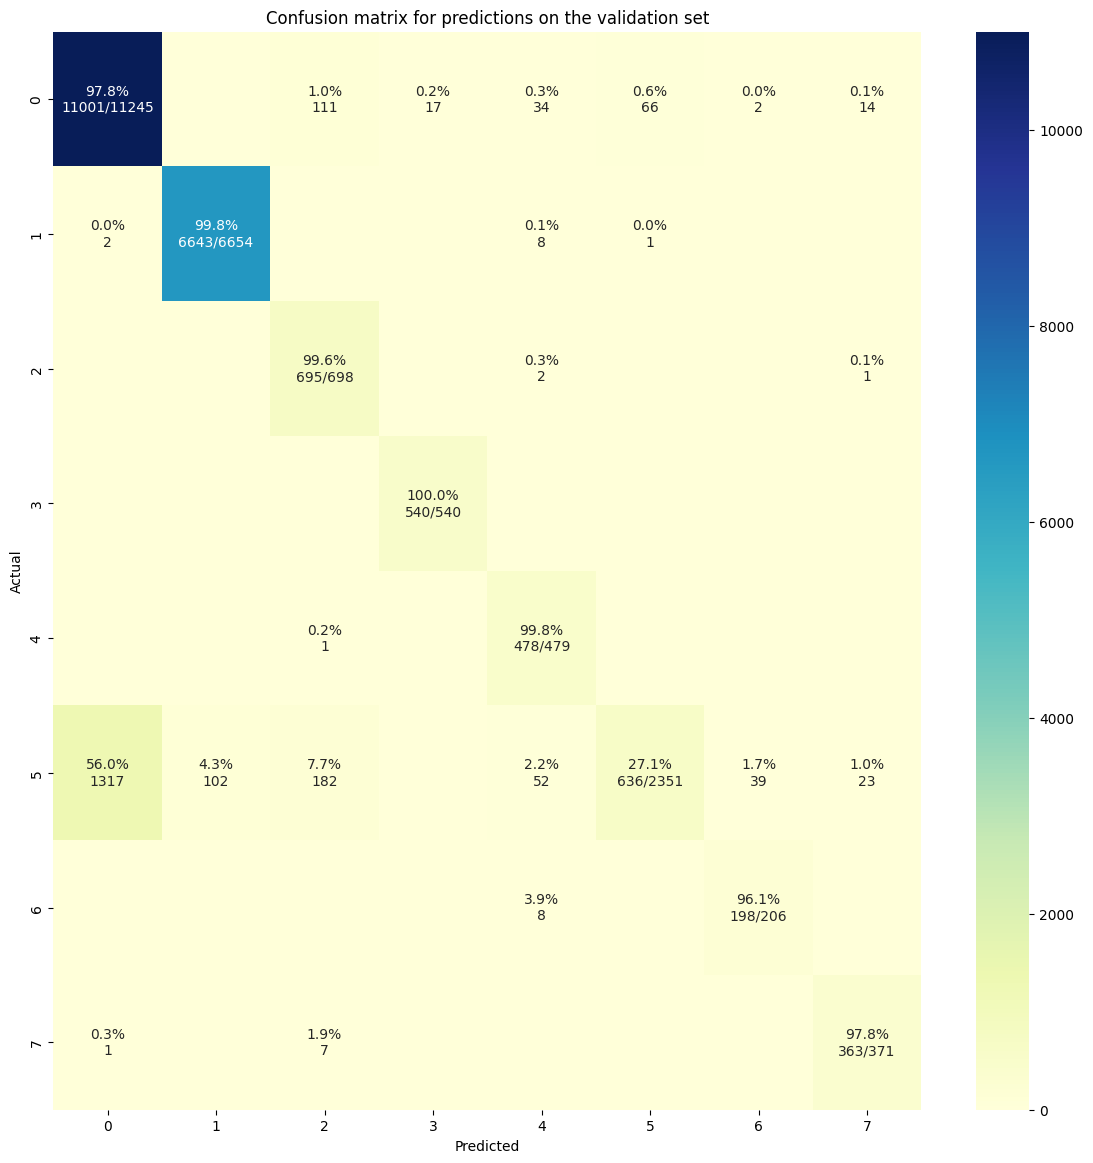

In [ ]:
plot_cm(y_test,y_pred, 'Confusion matrix for predictions on the validation set')
f1_score(y_test, y_pred, average = 'macro')

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 7, 0])

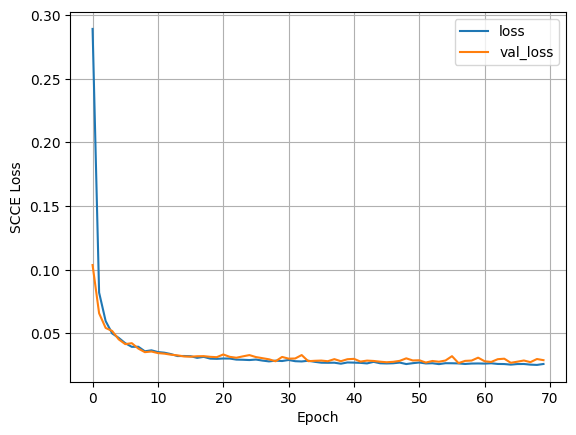

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

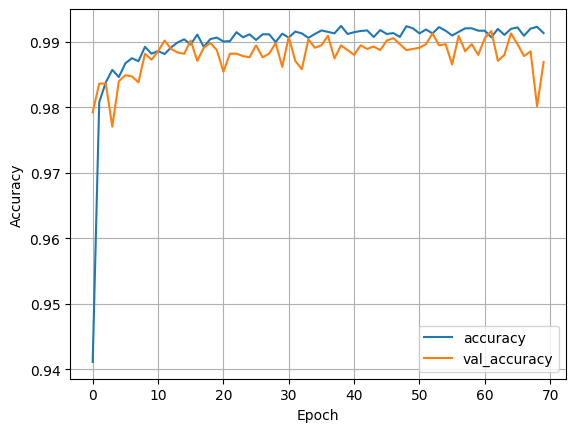

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)